Importing libraries

In [1]:
import pandas as pd 
import numpy as np 
import os
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as stats
from IPython.display import display, HTML

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb


train=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test= pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')



In [2]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [3]:
# # Find columns with missing values in the DataFrame
# missing_columns = train.loc[:, train.isnull().sum() > 0]

# # Display the DataFrame with only columns that have missing values
# missing_columns


total_rows=len(train)
# Create a DataFrame with column names, missing values, and percentage of missing values
missing_info = train.isnull().sum().reset_index()
missing_info.columns = ['column_name', 'missing_count']
missing_info['missing_percentage'] = (missing_info['missing_count'] / total_rows) * 100

# Filter to show only columns with missing values
missing_info = missing_info[missing_info['missing_count'] > 0]
missing_info

,column_name,missing_count,missing_percentage
3,LotFrontage,259,17.739726
6,Alley,1369,93.767123
25,MasVnrType,872,59.726027
26,MasVnrArea,8,0.547945
30,BsmtQual,37,2.534247
31,BsmtCond,37,2.534247
32,BsmtExposure,38,2.602740
33,BsmtFinType1,37,2.534247
35,BsmtFinType2,38,2.602740
42,Electrical,1,0.068493


In [4]:
test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [5]:
# Drop columns with >70% missing values
columns_to_drop = missing_info[missing_info['missing_percentage'] > 70]['column_name']
train = train.drop(columns=columns_to_drop)
test = test.drop(columns=columns_to_drop)
# Keep only columns in `test` that are also in `train`

train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,...,112,0,0,0,0,4,2010,WD,Normal,142125


In [6]:
test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,120,0,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,...,36,0,0,0,0,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,...,34,0,0,0,0,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,...,36,0,0,0,0,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,...,82,0,0,144,0,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,...,24,0,0,0,0,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,...,32,0,0,0,0,700,7,2006,WD,Normal


In [7]:
# Identify categorical and numerical columns
categorical_columns = train.select_dtypes(include=['object', 'category']).columns
numerical_columns = train.select_dtypes(include=['float64', 'int64']).columns
print("Categorical_cols: " + str(len(categorical_columns)))
print("Numerical_cols: " + str(len(numerical_columns)))

# Fill missing values
for col in numerical_columns:
    train[col].fillna(train[col].median(), inplace=True)

for col in categorical_columns:
    train[col].fillna(train[col].mode(), inplace=True)

Categorical_cols: 39
Numerical_cols: 38


In [8]:
# Function to identify columns with outliers using the IQR method
def find_outliers(df, numerical_columns):
    outlier_columns = []
    
    for col in numerical_columns:
        Q1 = df[col].quantile(0.25)  # First quartile (25th percentile)
        Q3 = df[col].quantile(0.75)  # Third quartile (75th percentile)
        IQR = Q3 - Q1               # Interquartile range
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Check if the column has any values outside the bounds
        if ((df[col] < lower_bound) | (df[col] > upper_bound)).any():
            outlier_columns.append(col)
    
    return outlier_columns

# Identify numerical columns
numerical_columns = train.select_dtypes(include=['number']).columns

# Find columns with outliers
columns_with_outliers = find_outliers(train, numerical_columns)
print(f"Columns with outliers: {columns_with_outliers}")
len(columns_with_outliers)

Columns with outliers: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']


32

In [9]:
train.drop('PoolArea',axis=1,inplace=True)
test.drop('PoolArea',axis=1,inplace=True)

In [10]:
# Select only numeric columns
numeric_cols = train.select_dtypes(include=['float64','int64'])

# Calculate correlations
correlation = numeric_cols.corr()

# Select columns with high correlation to 'SalePrice'
high_corr_cols = correlation['SalePrice'][correlation['SalePrice'].abs() > 0.5].index.tolist()
high_corr_cols.remove('SalePrice')  # Exclude the target variable itself
print("Highly correlated columns:", high_corr_cols)

Highly correlated columns: ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea']


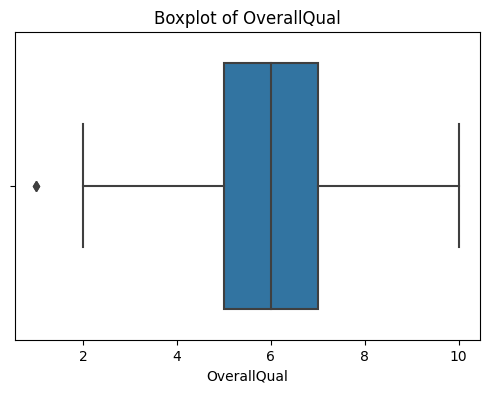

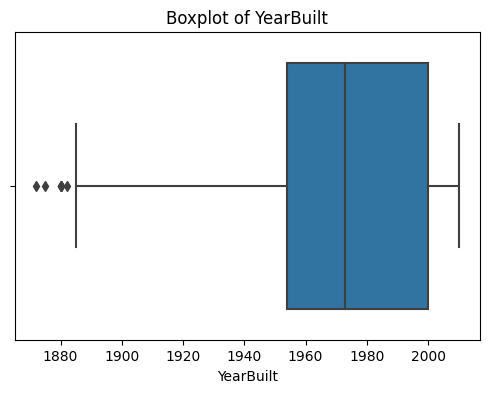

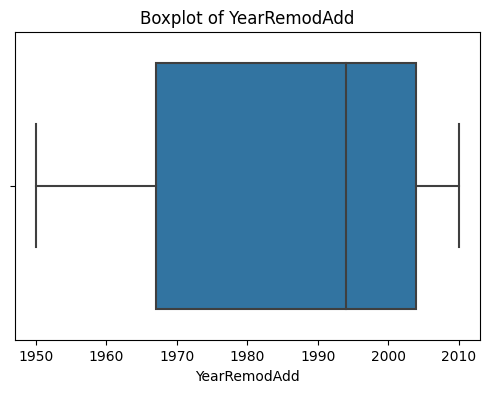

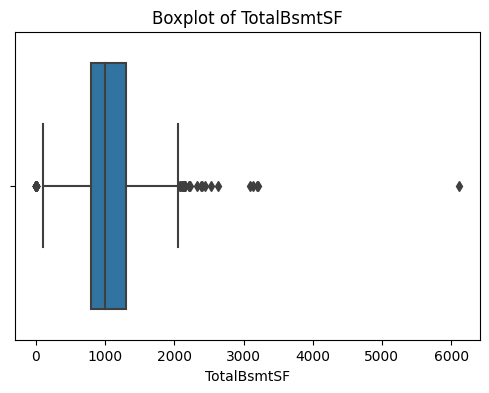

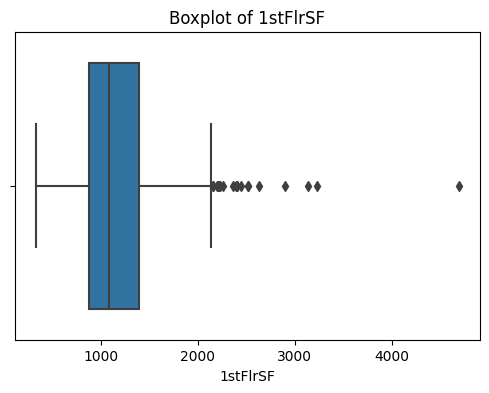

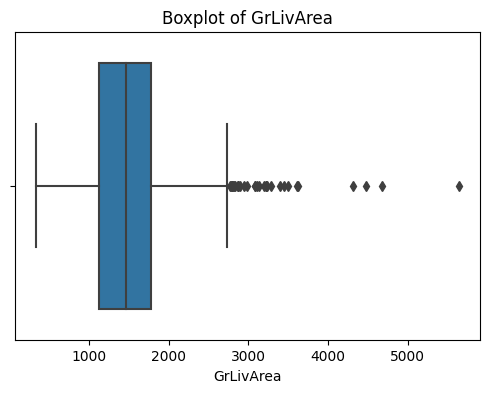

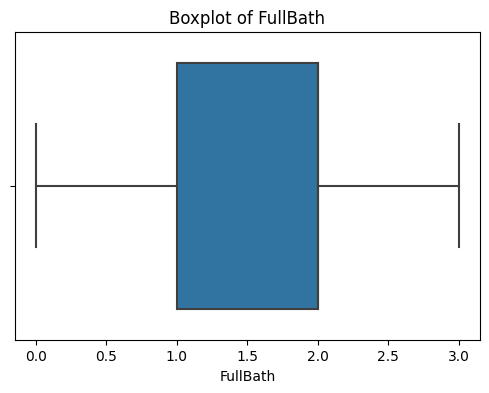

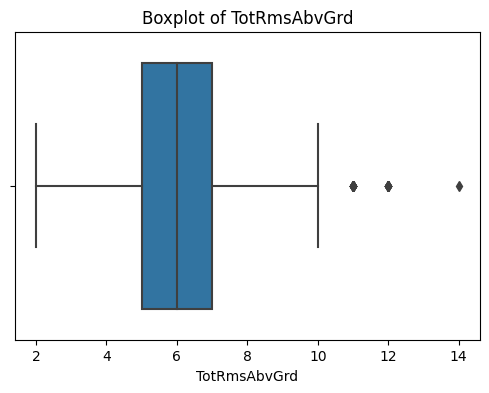

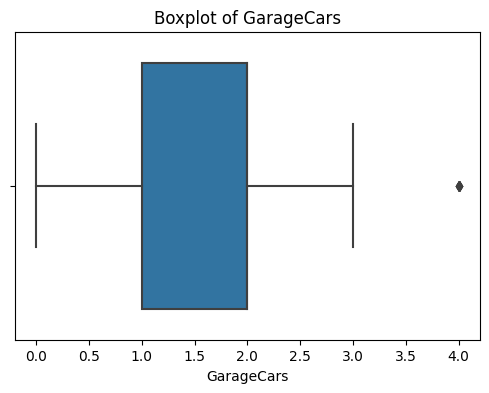

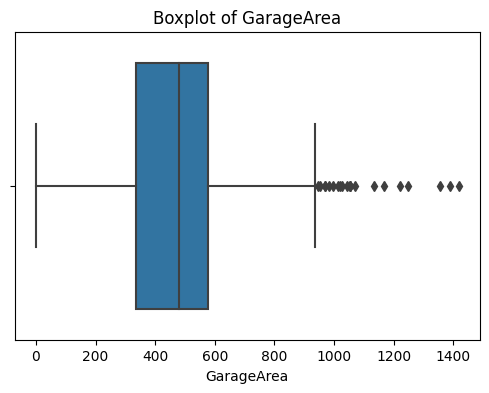

In [11]:
for col in high_corr_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=train[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [12]:
for col in high_corr_cols:
    Q1 = train[col].quantile(0.25)  # 25th percentile
    Q3 = train[col].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1

    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out rows outside bounds
    train = train[(train[col] >= lower_bound) & (train[col] <= upper_bound)]


In [13]:
print(f"Remaining rows train: {train.shape[0]}")
print(f"Remaining columns train: {train.shape[1]}")

print(f"Remaining rows test: {test.shape[0]}")
print(f"Remaining columns test: {test.shape[1]}")

Remaining rows train: 1331
Remaining columns train: 76
Remaining rows test: 1459
Remaining columns test: 75


In [14]:
# Identify skewed columns (optional: only apply to highly correlated ones)
skewed_cols = numeric_cols.skew()[numeric_cols.skew().abs() > 0.75].index
train[skewed_cols] = np.log1p(train[skewed_cols])
skewed_cols

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'MiscVal', 'SalePrice'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


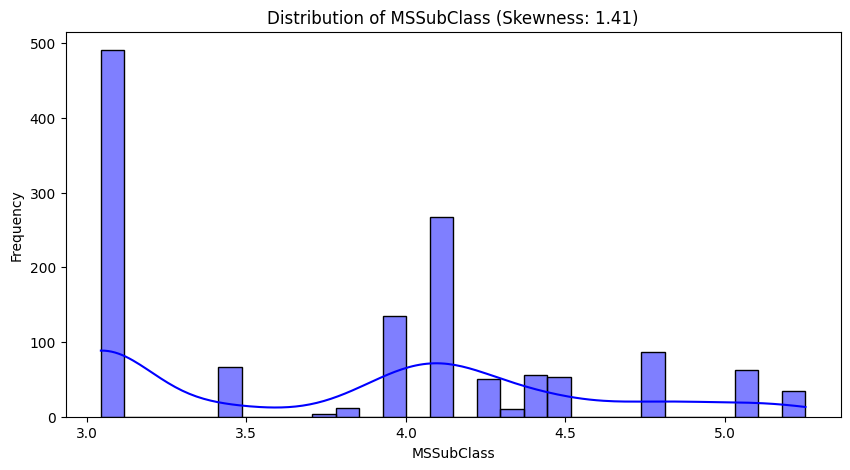

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


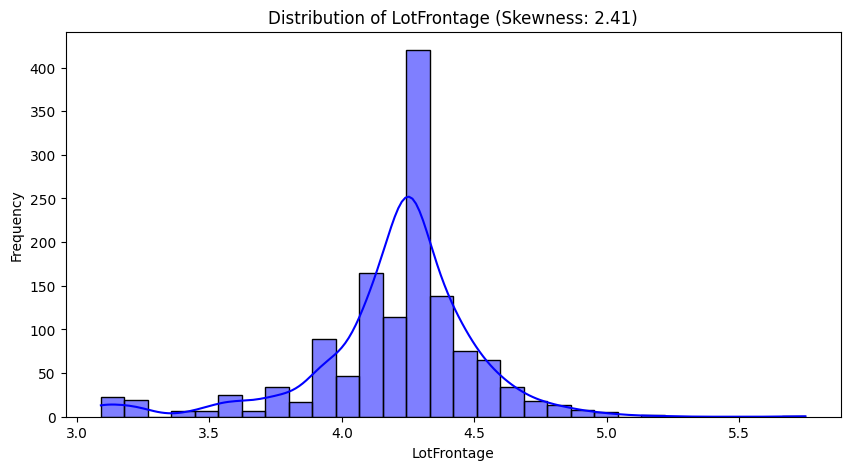

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


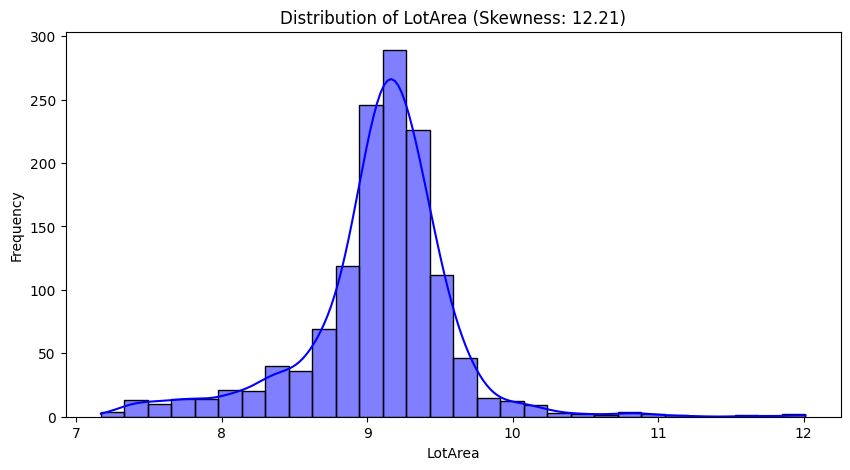

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


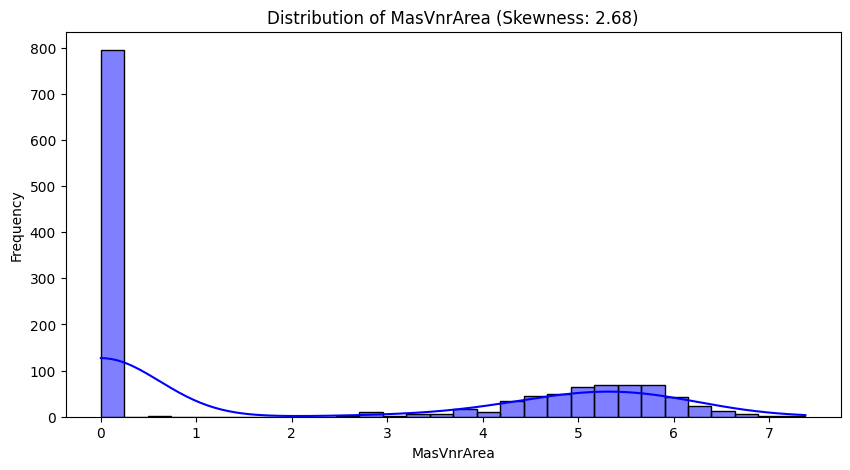

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


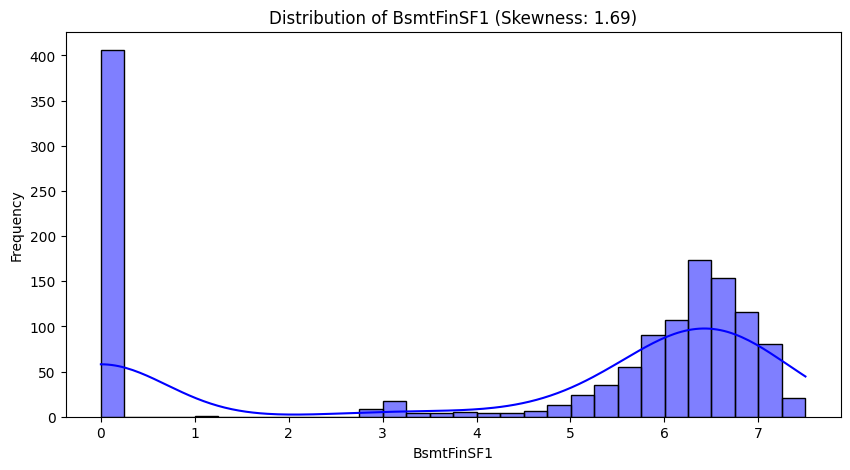

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


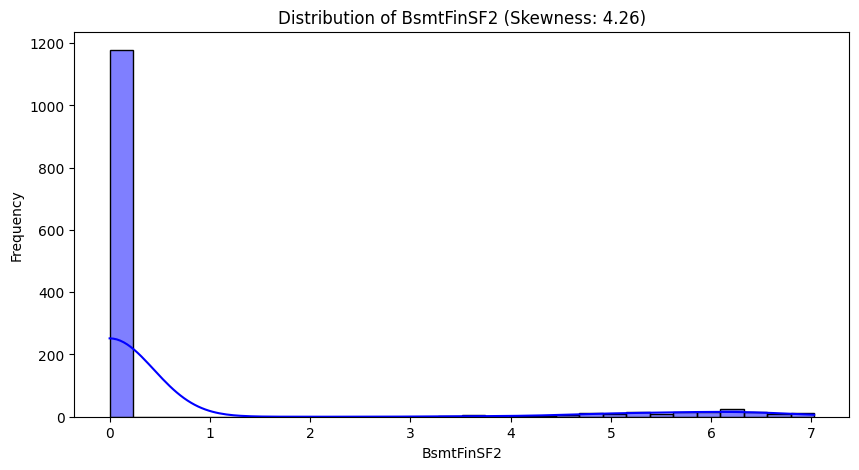

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


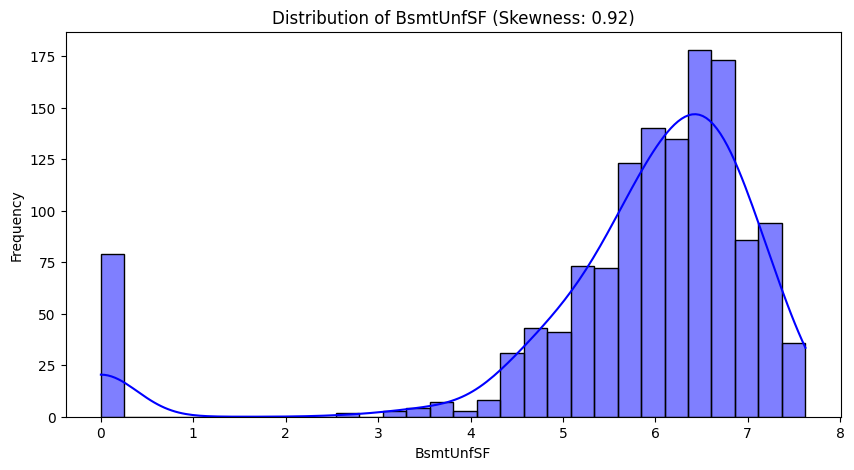

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


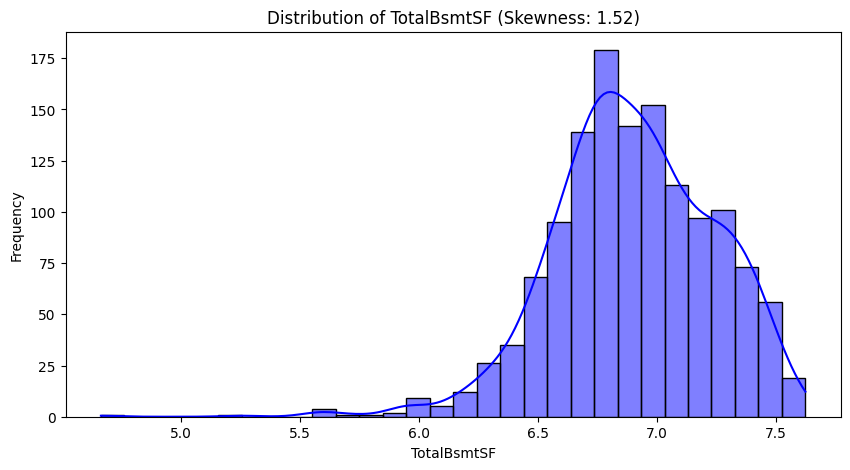

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


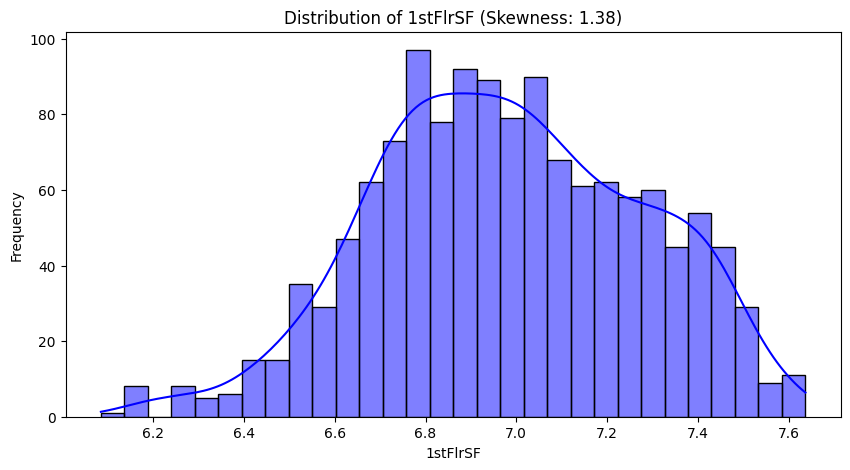

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


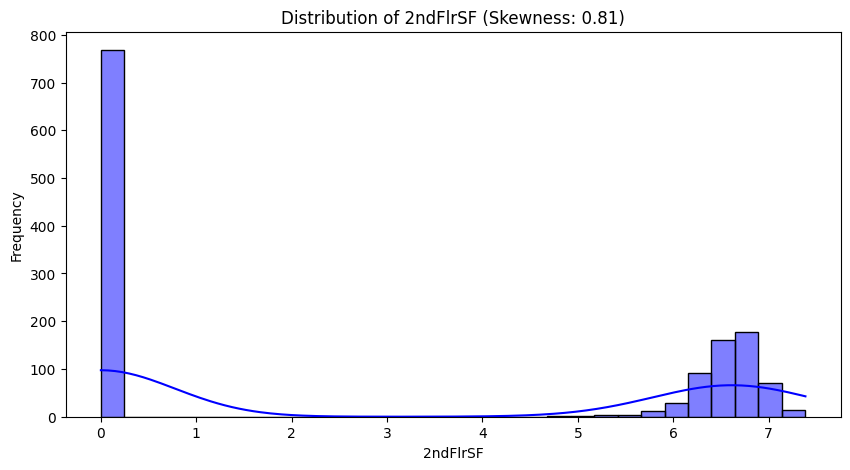

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


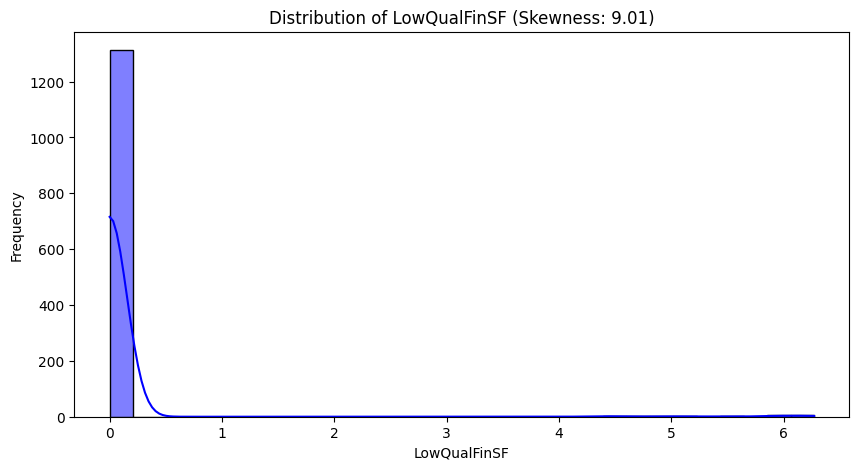

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


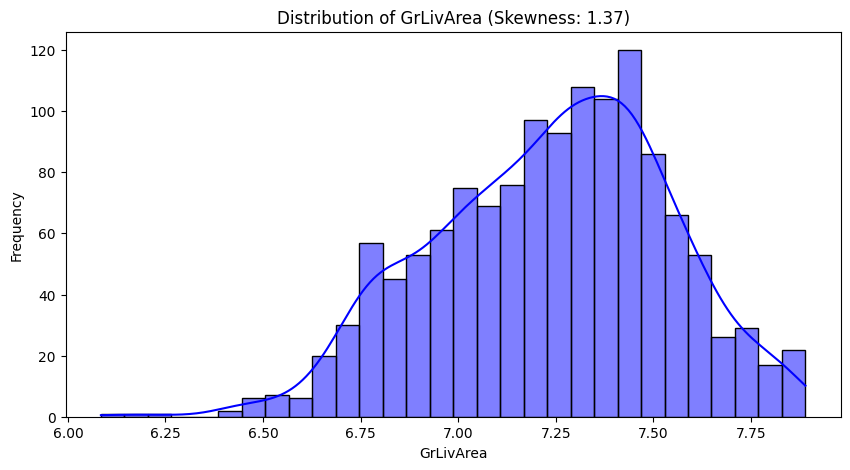

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


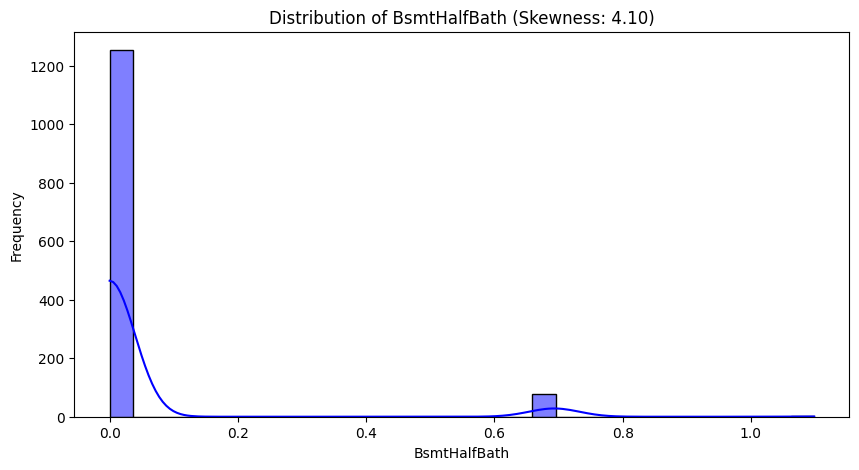

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


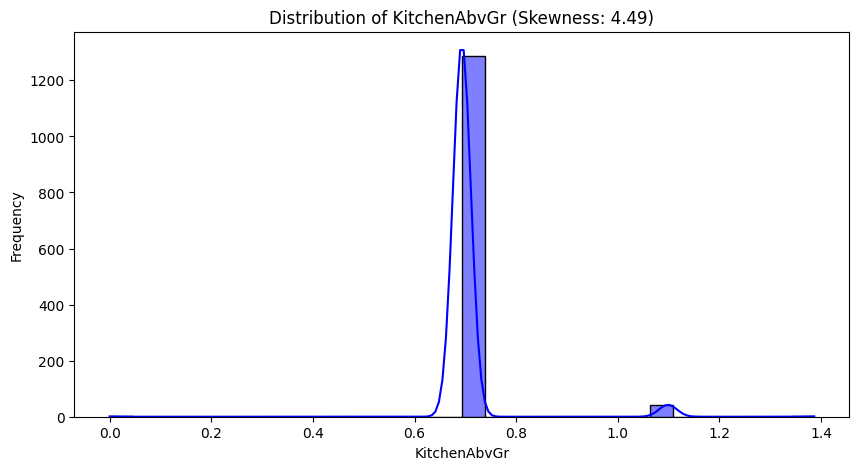

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


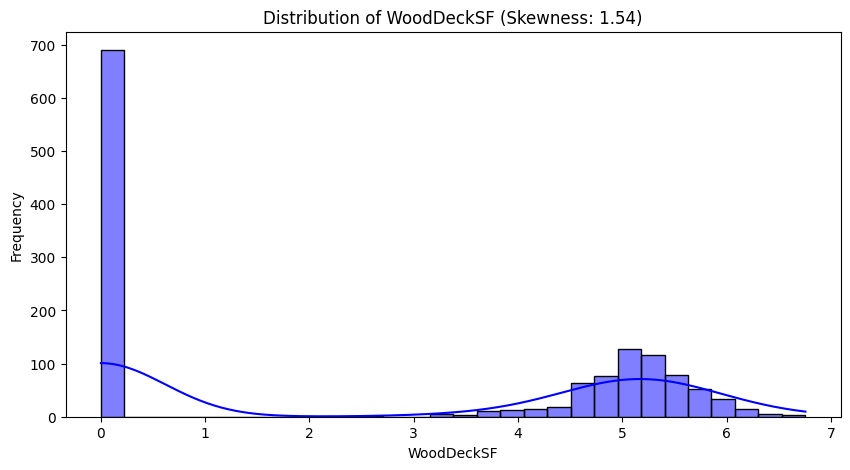

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


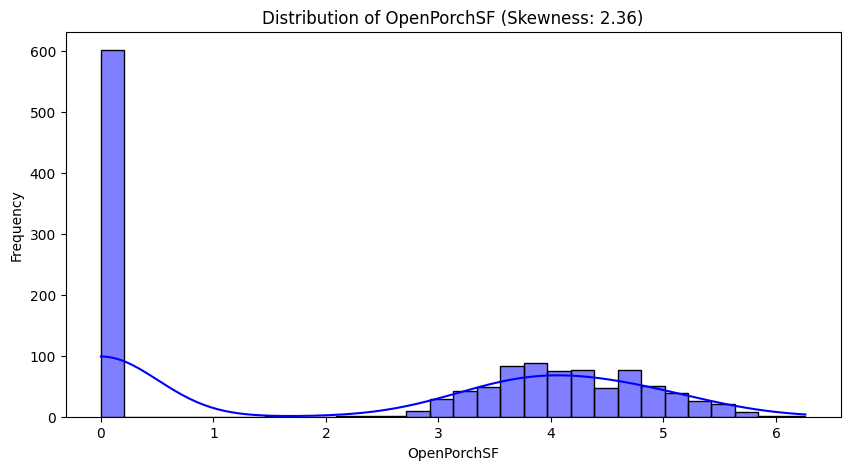

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


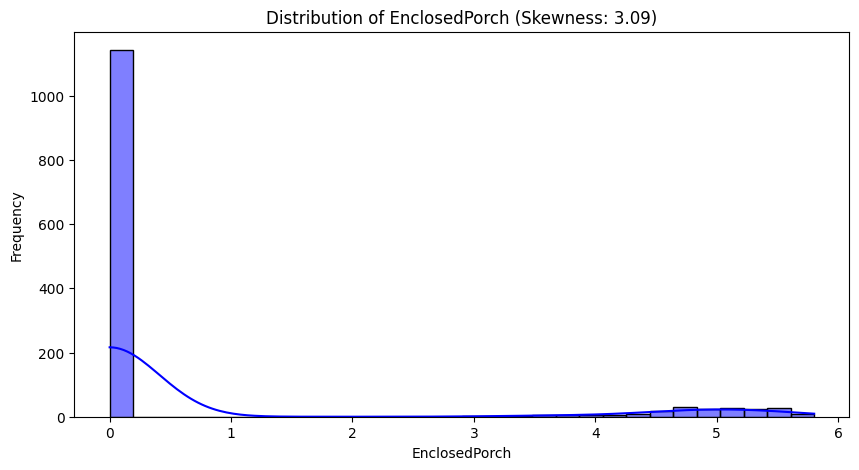

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


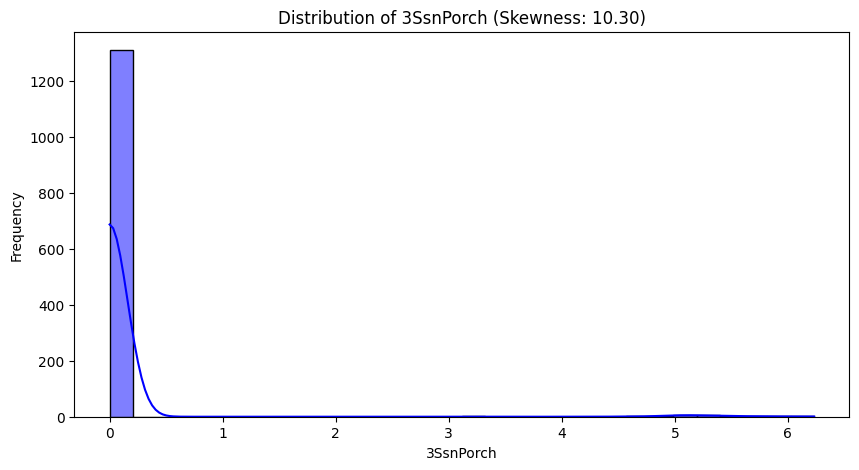

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


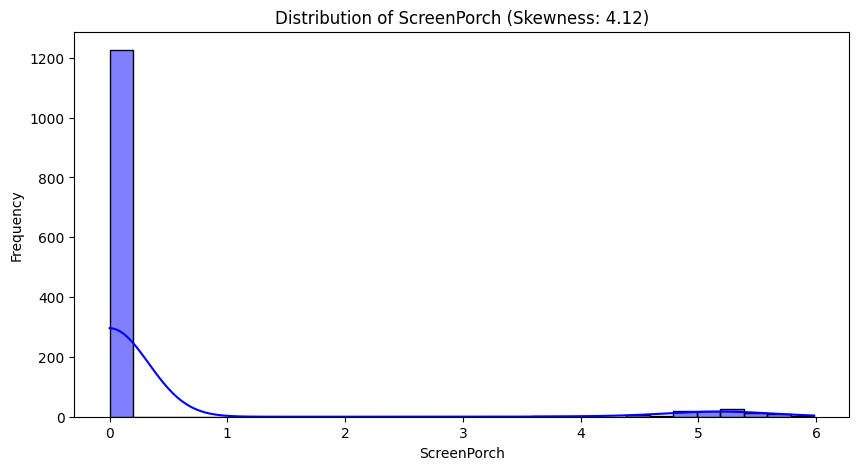

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


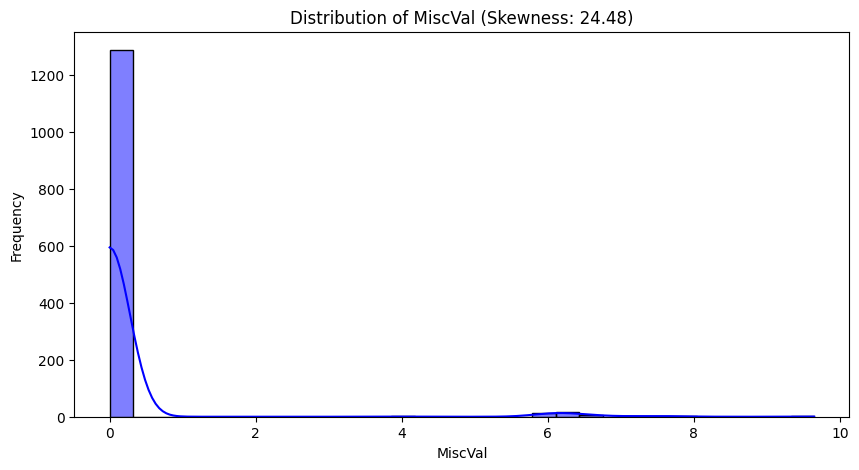

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


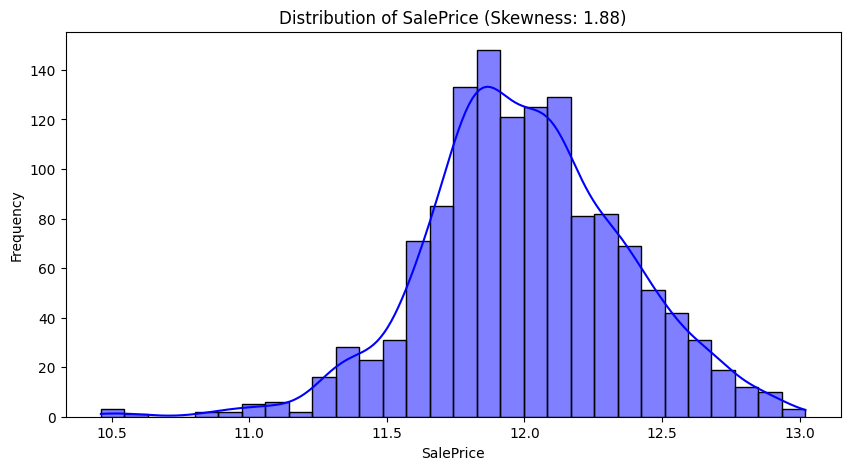

In [15]:
# Plot the skewed columns
for col in skewed_cols:
    plt.figure(figsize=(10, 5))
    
    # Histogram
    sns.histplot(train[col], kde=True, bins=30, color='blue')
    plt.title(f"Distribution of {col} (Skewness: {numeric_cols[col].skew():.2f})")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    
    plt.show()

In [16]:
# Select categorical columns
categorical_cols = train.select_dtypes(include=['object', 'category']).columns

# Check unique values for each column
for col in categorical_cols:
    print(f"{col}: {train[col].unique()}")


MSZoning: ['RL' 'RM' 'C (all)' 'FV' 'RH']
Street: ['Pave' 'Grvl']
LotShape: ['Reg' 'IR1' 'IR2' 'IR3']
LandContour: ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities: ['AllPub' 'NoSeWa']
LotConfig: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope: ['Gtl' 'Mod' 'Sev']
Neighborhood: ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NAmes' 'SawyerW' 'NridgHt' 'IDOTRR'
 'MeadowV' 'Timber' 'Gilbert' 'ClearCr' 'Edwards' 'NPkVill' 'StoneBr'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1: ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'RRNe' 'PosA']
Condition2: ['Norm' 'Artery' 'RRNn' 'Feedr' 'RRAn']
BldgType: ['1Fam' '2fmCon' 'TwnhsE' 'Duplex' 'Twnhs']
HouseStyle: ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle: ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMatl: ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll']
Exterior1st: ['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'CemntBd' 'P

In [17]:
#Categorical Encoding
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
train[categorical_cols] = ordinal_encoder.fit_transform(train[categorical_cols])
test[categorical_cols] = ordinal_encoder.fit_transform(test[categorical_cols])
test[categorical_cols]

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,2.0,1.0,3.0,3.0,0.0,4.0,0.0,12.0,1.0,2.0,...,3.0,6.0,NaN,1.0,2.0,3.0,4.0,2.0,8.0,4.0
1,3.0,1.0,0.0,3.0,0.0,0.0,0.0,12.0,2.0,2.0,...,2.0,6.0,NaN,1.0,2.0,3.0,4.0,2.0,8.0,4.0
2,3.0,1.0,0.0,3.0,0.0,4.0,0.0,8.0,2.0,2.0,...,3.0,6.0,4.0,1.0,0.0,3.0,4.0,2.0,8.0,4.0
3,3.0,1.0,0.0,3.0,0.0,4.0,0.0,8.0,2.0,2.0,...,2.0,6.0,2.0,1.0,0.0,3.0,4.0,2.0,8.0,4.0
4,3.0,1.0,0.0,1.0,0.0,4.0,0.0,22.0,2.0,2.0,...,2.0,6.0,NaN,1.0,1.0,3.0,4.0,2.0,8.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,4.0,1.0,3.0,3.0,0.0,4.0,0.0,10.0,2.0,2.0,...,3.0,6.0,NaN,NaN,NaN,NaN,NaN,2.0,8.0,4.0
1455,4.0,1.0,3.0,3.0,0.0,4.0,0.0,10.0,2.0,2.0,...,3.0,6.0,NaN,4.0,2.0,3.0,4.0,2.0,8.0,0.0
1456,3.0,1.0,3.0,3.0,0.0,4.0,0.0,11.0,2.0,2.0,...,3.0,6.0,4.0,5.0,2.0,3.0,4.0,2.0,8.0,0.0
1457,3.0,1.0,3.0,3.0,0.0,4.0,0.0,11.0,2.0,2.0,...,3.0,6.0,NaN,NaN,NaN,NaN,NaN,2.0,8.0,4.0


In [18]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodD

In [19]:
# Identify categorical and numerical columns
categorical_columns = train.select_dtypes(include=['object', 'category']).columns
numerical_columns = train.select_dtypes(include=['float64', 'int64']).columns
print("Categorical_cols: " + str(len(categorical_columns)))
print("Numerical_cols: " + str(len(numerical_columns)))


# Fill missing values
for col in numerical_columns:
    train[col].fillna(train[col].median(), inplace=True)

for col in categorical_columns:
    train[col].fillna(train[col].mode(), inplace=True)


Categorical_cols: 0
Numerical_cols: 76


In [20]:
# Identify categorical and numerical columns
categorical_columns = test.select_dtypes(include=['object', 'category']).columns
numerical_columns = test.select_dtypes(include=['float64', 'int64']).columns
print("Categorical_cols: " + str(len(categorical_columns)))
print("Numerical_cols: " + str(len(numerical_columns)))


for col in numerical_columns:
    test[col].fillna(test[col].median(), inplace=True)

for col in categorical_columns:
    test[col].fillna(test[col].mode(), inplace=True)


Categorical_cols: 0
Numerical_cols: 75


In [21]:
total_rows=len(train)
# Create a DataFrame with column names, missing values, and percentage of missing values
missing_info_train = train.isnull().sum().reset_index()
missing_info_train.columns = ['column_name', 'missing_count']
missing_info_train['missing_percentage'] = (missing_info_train['missing_count'] / total_rows) * 100

# Filter to show only columns with missing values
missing_info_train = missing_info_train[missing_info_train['missing_count'] > 0]
print(missing_info_train)

Empty DataFrame
Columns: [column_name, missing_count, missing_percentage]
Index: []


In [22]:
total_rows=len(test)
# Create a DataFrame with column names, missing values, and percentage of missing values
missing_info_test = test.isnull().sum().reset_index()
missing_info_test.columns = ['column_name', 'missing_count']
missing_info_test['missing_percentage'] = (missing_info_test['missing_count'] / total_rows) * 100

# Filter to show only columns with missing values
missing_info_test = missing_info_test[missing_info_test['missing_count'] > 0]
print(missing_info_test)

Empty DataFrame
Columns: [column_name, missing_count, missing_percentage]
Index: []


In [23]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_features = train.select_dtypes(include=['float64', 'int64']).columns
train[num_features] = scaler.fit_transform(train[num_features])

In [24]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodD

In [25]:
from sklearn.model_selection import train_test_split

X = train.drop('SalePrice', axis=1)  # Features
y = train['SalePrice'] 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)



from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


from xgboost import XGBRegressor

# Initialize the XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=100,  # Number of trees (similar to Random Forest)
    learning_rate=0.1,  # Step size shrinkage to prevent overfitting
    max_depth=3,       # Maximum depth of a tree
    random_state=42    # Ensures reproducibility
)

# Fit the model to the training data
xgb_model.fit(X_train, y_train)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predictions
y_pred_rf = rf_model.predict(X_val)
y_pred_lr= lr_model.predict(X_val)
y_pred_xg = xgb_model.predict(X_val)
# Metrics
print("MAE LR:", mean_absolute_error(y_val, y_pred_lr))
print("RMSE LR:", np.sqrt(mean_squared_error(y_val, y_pred_lr)))
print("R² Score LR:", r2_score(y_val, y_pred_lr))

print("MAE RF:", mean_absolute_error(y_val, y_pred_rf))
print("RMSE RF:", np.sqrt(mean_squared_error(y_val, y_pred_rf)))
print("R² Score RF:", r2_score(y_val, y_pred_rf))

print("MAE XGB:", mean_absolute_error(y_val, y_pred_xg))
print("RMSE XGB:", np.sqrt(mean_squared_error(y_val, y_pred_xg)))
print("R² Score XGB:", r2_score(y_val, y_pred_xg))




MAE LR: 0.23452420857133147
RMSE LR: 0.34486291425353416
R² Score LR: 0.8494195399853457
MAE RF: 0.23666575359620123
RMSE RF: 0.32753850378287297
R² Score RF: 0.8641685448026232
MAE XGB: 0.22413108780489008
RMSE XGB: 0.3070514260178941
R² Score XGB: 0.8806292646614409


In [28]:
y_pred= rf_model.predict(test)
y_pred

array([2.0290513 , 2.16676915, 2.05769378, ..., 2.09819631, 1.65058962,
       2.18521541])

In [29]:
# Create a submission file
submission = pd.DataFrame({
    'Id': test['Id'],  # Use the test dataset's IDs
    'SalePrice': y_pred  # Predicted prices
})
submission.to_csv('submission.csv', index=False)
